# DCGAN with Keras

## Import libs

In [29]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

import matplotlib.pyplot as plt
import imageio

from tqdm import tqdm
from IPython import display

import glob

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.0.0


## Define helpers

In [27]:
def show_imgs(images, n_cols = None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols * 2, n_rows * 2))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap = "binary")
        plt.axis("off")

## Get the data

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
# Normalize pics
X_train = X_train.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

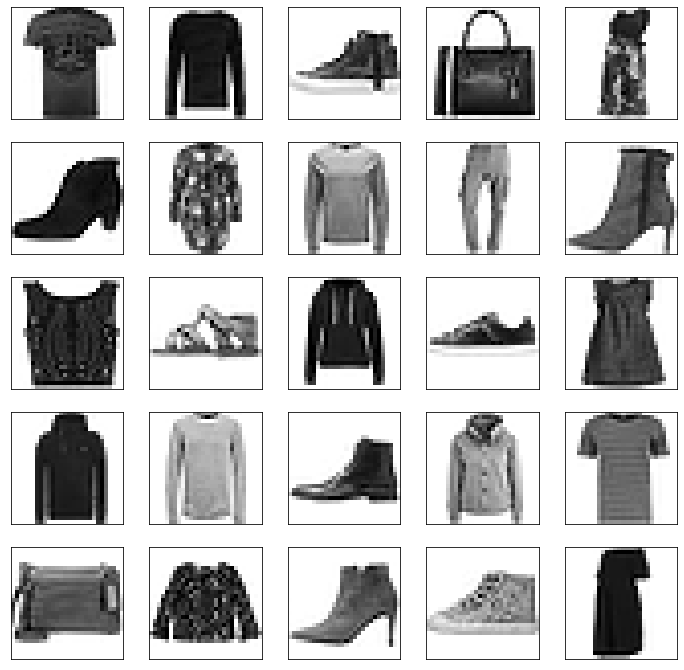

In [4]:
# Visualize a couple of pics
plt.figure(figsize = (12, 12))

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[np.random.randint(0, 1e4)], cmap = plt.cm.binary)

## Build the dataset

In [7]:
# Set batch size
BATCH_SIZE = 32

# Create dataset
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(BATCH_SIZE, drop_remainder = True).prefetch(1)

## Build the Generator 

**Generator** is an upsampling network with fractionally-strided convolutions

**Discriminator** is a convolutional network

[Source](https://arxiv.org/pdf/1511.06434.pdf): Radford et al, "*Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks*", ICLR 2016

In [8]:
n_features = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape = [n_features]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, (5, 5), (2, 2),   # Stride = 2x2
                                 padding = 'same', 
                                 activation = 'selu'), # SELU speeds up the training
    keras.layers.BatchNormalization(),                 # Without BN training collapses
    keras.layers.Conv2DTranspose(1, (5, 5), (2, 2),
                                 padding = 'same',
                                 activation = 'tanh')
])

In [9]:
# Create seed
noise = tf.random.normal(shape = [1, n_features])

# Generate pic without training
generated_img = generator(noise, training = False)

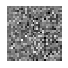

In [10]:
show_imgs(generated_img, 1)

## Build the Discriminator 

In [11]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, (5, 5), (2, 2), 
                        padding = 'same',
                        input_shape = [28, 28, 1]),
    keras.layers.LeakyReLU(.2),
    keras.layers.Dropout(.3),
    keras.layers.Conv2D(128, (5, 5), (2, 2), 
                        padding = 'same'),
    keras.layers.LeakyReLU(.2),
    keras.layers.Dropout(.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation = 'sigmoid')
])

In [12]:
# Check untrained discriminator
discriminator(generated_img)

<tf.Tensor: id=656, shape=(1, 1), dtype=float32, numpy=array([[0.5006725]], dtype=float32)>

## Compile the model

In [13]:
# Compile discriminator
discriminator.compile(loss = 'binary_crossentropy',
                      optimizer = 'rmsprop')

# For the first part of training we only train the generator
discriminator.trainable = False

In [14]:
# Create GAN
gan = keras.models.Sequential([generator, discriminator])

# Compile GAN
gan.compile(loss = 'binary_crossentropy',
            optimizer = 'rmsprop')

## Define the training

In [15]:
seed_vector = tf.random.normal(shape = [BATCH_SIZE, n_features])

In [16]:
# Create training func

def train_dcgan(gan, dataset, batch_size, n_features, epochs = 5):
    
    generator, discriminator = gan.layers
    
    for epoch in tqdm(range(epochs)):
        print(f'Epoch: {epoch + 1}/{epochs}')
        
        for X_batch in dataset:
            
            # Generate fake images
            noise = tf.random.normal(shape = [batch_size, n_features])
            gen_imgs = generator(noise)
            
            # Concatenate fake and real imgs and generate labels
            X_fake_and_real = tf.concat([gen_imgs, X_batch], axis = 0)
            y_1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            
            # Train the discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y_1)
            
            # Train the generator
            y_2 = tf.constant([[1.]] * batch_size)
            
            discriminator.trainable = False
            
            # Train the generator
            gan.train_on_batch(noise, y_2)
            
        # Visualizations
        display.clear_output(wait = True)
        generate_and_save_images(generator, epoch + 1, seed_vector)

    display.clear_output(wait = True)
    generate_and_save_images(generator, epochs, seed_vector) 
    

In [17]:
## Source https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
def generate_and_save_images(model, epoch, test_input):
    
    predictions = model(test_input, training = False)
    fig = plt.figure(figsize=(10,10))
    
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
        plt.axis('off')
        
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## Train the model

In [18]:
# Reshape and scale to [-1, 1] for tanh
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1

In [19]:
BATCH_SIZE = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan).shuffle(1000)
dataset = dataset.batch(BATCH_SIZE, drop_remainder = True).prefetch(1)

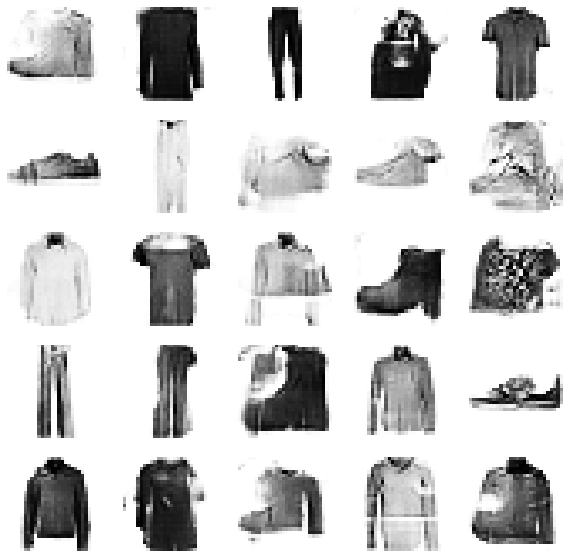

Wall time: 2h 59min 42s


In [20]:
%%time
# Train DCGAN
train_dcgan(gan, dataset, BATCH_SIZE, n_features, epochs = 20)

## Generate synthetic images

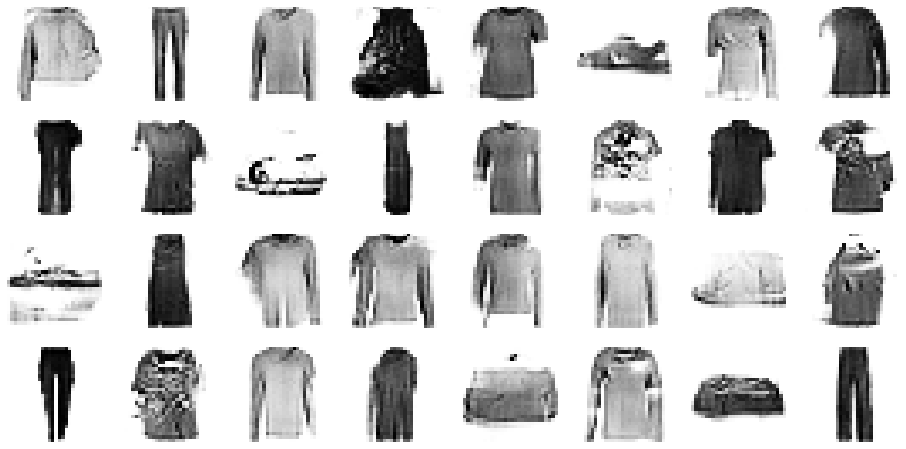

In [28]:
noise = tf.random.normal(shape = [BATCH_SIZE, n_features])
gen_imgs = generator(noise)
show_imgs(gen_imgs, 8)

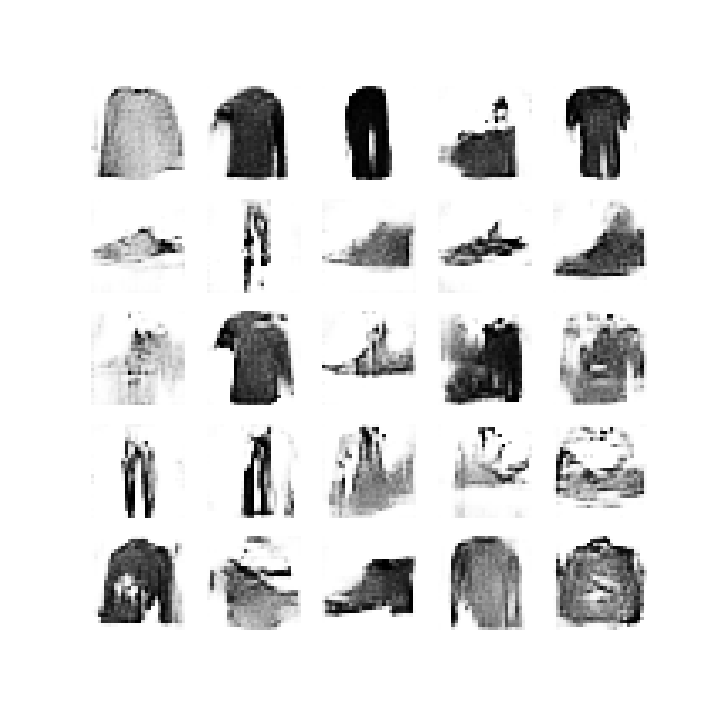

In [30]:
# Create a gif 
## Source: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode = 'I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2 * (i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
display.Image(filename = anim_file)